
# Forecasting Sales using ARIMA or Seasonal ARIMA


### Autoregressive Integrated Moving Average (ARIMA)

The general process for ARIMA models is the following:
* Load the Time Series Data
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data.

Difference between ARIMA and SARIMA; https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
* Use the model to make predictions



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

download dataset; https://www.kaggle.com/anupamshah/perrin-freres-monthly-champagne-sales

#### Problem Description
The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

The values are a count of millions of sales and there are 105 observations.

### Step 1: Data Preprocessing

In [16]:
# read the downloaded .csv file from you working directory
df=pd.read_csv('perrin-freres-monthly-champagne.csv')

In [17]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [18]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [19]:
## Renaming column headers
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [20]:
# Check for NaNs within the dataframe....if any remove the row containing it
df.isnull()

,Month,Sales
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
102,False,False
103,False,False
104,False,False
105,True,True


In [21]:
# count NaN per column
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [22]:
# Removing rows with NaN
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

df.dropna(axis=0,how='any', thresh=None, subset=None, inplace=True)
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [23]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [24]:
# The Month column is of type object. Convert it into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [25]:
# convert the table data into a time series data
df.set_index('Month',inplace=True)
df.head(12)

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0
1964-08-01,2212.0
1964-09-01,2922.0


In [26]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


### Step 2: Visualize the Data

<AxesSubplot:xlabel='Month'>

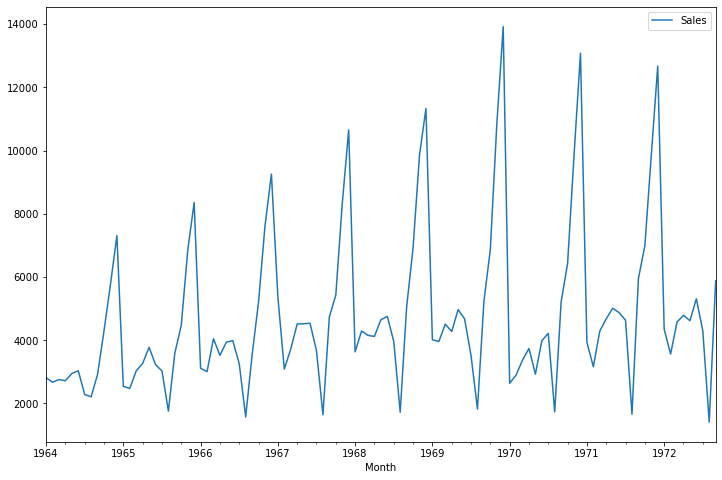

In [27]:
df.plot(figsize=(12,8))

In [33]:
import plotly.express as px

px.line(df, y="Sales", title="Sales Trend")

The ARIMA(p,d,q) model requires three parameters.

Analysis of the time series data assumes that we are working with a stationary time series.

To be sure we perform check(s) for stationarity by either;
1. *Direct observations* by looking at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
2. *Summary Statistics*: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
3. *Statistical Tests*: You can use statistical tests (e.g **Dickey Fuller**) to check if the expectations of stationarity are met or have been violated.

Further reading; https://machinelearningmastery.com/time-series-data-stationary-python/


In [48]:
# Testing For Stationarity using Dickey Fuller test

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        # strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root thus stationary
        print("The data is stationary")
    else:
        # weak evidence against null hypothesis, accept the null hypothesis. The time series has a unit root thus non-stationary
        print("The data is non-stationary")


In [49]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276226
p-value : 0.3639157716602452
#Lags Used : 11
Number of Observations Used : 93
The data is non-stationary


p-value is > 0.05 so we accept Null Hypothises, proving that data(Sales) is not Stationary.

Now, we can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

### Step 3: Make the data stationary

#### Differencing

*Differencing* in statistics is a transformation applied to a non-stationary time-series in order to make it stationary in the mean sense (viz., to remove the non-constant trend), but having nothing to do with the non-stationarity of the variance/autocovariance. Likewise, the **seasonal differencing** is applied to a seasonal time-series to remove the seasonal component.

Further reading; https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

In [50]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [51]:
df.head(14)

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [52]:
## Again test dickey fuller test on the newly generated column
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
The data is stationary


p-value is < 0.05 , proving that new column data(Seasonal First Difference) is now stationary (i.e  does not have time-dependent structure).


<AxesSubplot:xlabel='Month'>

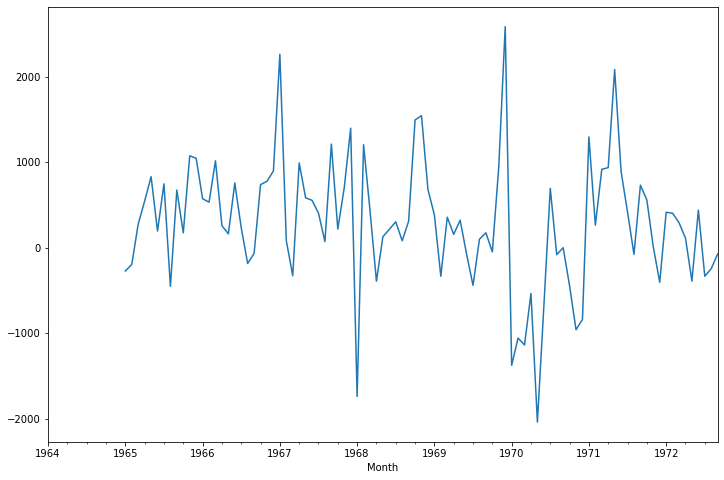

In [53]:
# to visualize the stationarized new column
df['Seasonal First Difference'].plot(figsize=(12,8))

A plot of the differenced dataset is created above.

The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling, since the differenced dataset it stationary.

### Step 4: Plot the Correlation and AutoCorrelation Charts

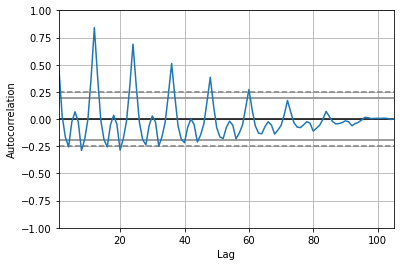

In [54]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

### Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
Determine (p,d,q)
    
    p - AR model lags
    
    d - differencing
    
    q - MA lags

d=1, since we only needed the first differencing to get a stationary dataset

The next first step is to select the lag values for the **AutoRegression (AR)** and **Moving Average (MA)** parameters, **p** and **q** respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Note, we are now using the timestamp index and the new seasonally differenced stationary column as our dataset.


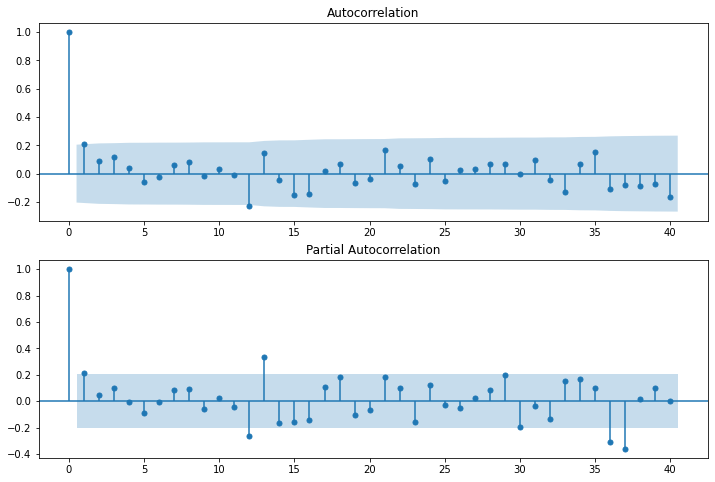

In [55]:
# Creating ACF and PACF plots for the series.
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

Determine p,q values from the plots above

p=1, q=1

### Step 5: Construct the ARIMA Model or Seasonal ARIMA based on the data.

For non-seasonal data we would use ARIMA with;
         p=1, d=1, q=0 or 1
And the code would be;

        from statsmodels.tsa.arima_model import ARIMA
        model=ARIMA(df['Sales'],order=(1,1,1))
        model_fit=model.fit()
        model_fit.summary()
        # to visualize
        df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
        df[['Sales','forecast']].plot(figsize=(12,8))
        

**But since we are dealing with seasonal data we use Seasonal ARIMA**

The SARIMA time series forecasting method is supported in Python via the **Statsmodels** library.


#### To use SARIMA there are three steps, they are:

   1. *Define the model*. (import statsmodels.api as sm, then implement SARIMA using *SARIMAX()* class)
   
The implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.

   2. *Fit the defined model*. (fit the model on the training data using .fit())
   
   3. *Make a prediction with the fit model*.
Once fit, the model can be used to make a forecast.
A forecast can be made by calling the *forecast()* or the *predict()* functions on the SARIMAXResults object returned from calling fit.

Futher reading; https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/


In [56]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

C:\ProgramData\Anaconda3\envs\deepln\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\deepln\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Thu, 29 Jul 2021   AIC                           1486.804
Time:                                    17:34:06   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
df.tail(5)

,Sales,Seasonal First Difference
Month,,
1972-05-01,4618.0,-392.0
1972-06-01,5312.0,438.0
1972-07-01,4298.0,-335.0
1972-08-01,1413.0,-246.0
1972-09-01,5877.0,-74.0


In [58]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)

# compare "Sales" and "Forecast"
df.tail(10)

,Sales,Seasonal First Difference,forecast
Month,,,
1971-12-01,12670.0,-406.0,13632.324168
1972-01-01,4348.0,414.0,3832.960291
1972-02-01,3564.0,402.0,3313.096629
1972-03-01,4577.0,291.0,4285.475160
1972-04-01,4788.0,112.0,4701.091607
1972-05-01,4618.0,-392.0,4717.508971
1972-06-01,5312.0,438.0,4906.403010
1972-07-01,4298.0,-335.0,4685.434798
1972-08-01,1413.0,-246.0,2232.407747


<AxesSubplot:xlabel='Month'>

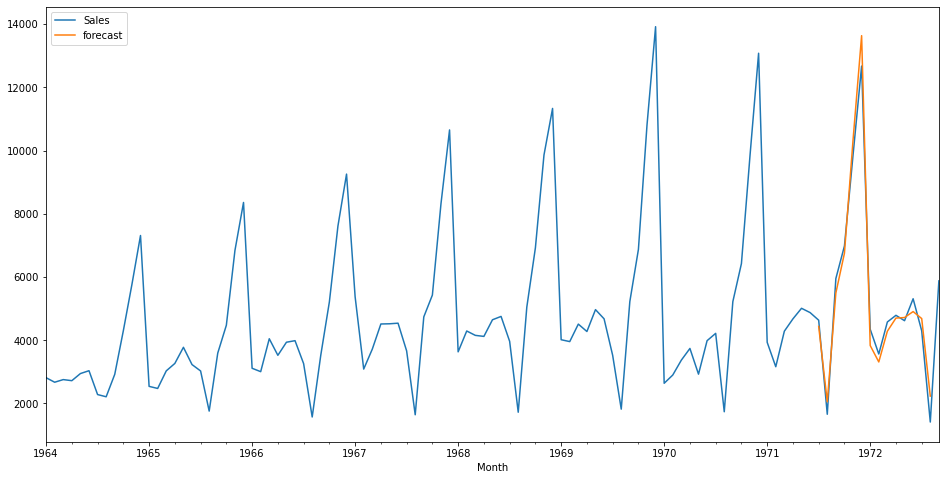

In [59]:
# Visualize (Validation)
df[['Sales','forecast']].plot(figsize=(16,8))

Once satisfied with the model accuracy you can continue to future forecasting.

### Step 6: Future Prediction and Forecasting

In [60]:
# Adding Future Dates to the Dataset.

from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_dates_df

,Sales,Seasonal First Difference,forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN


In [61]:
future_dates_df.shape

(23, 3)

In [62]:
future_df=pd.concat([df,future_dates_df])
len(future_df)

128

Therefore we have to future predict (column='forecast') from row 104 to row 128

In [63]:
future_df['forecast'] = results.predict(start = 104, end = 128, dynamic= True)

future_df.tail(24)

,Sales,Seasonal First Difference,forecast
1972-09-01,5877.0,-74.0,5878.711546
1972-10-01,NaN,NaN,7024.262717
1972-11-01,NaN,NaN,9996.420199
1972-12-01,NaN,NaN,12892.153925
1973-01-01,NaN,NaN,4561.508474
1973-02-01,NaN,NaN,3718.817026
1973-03-01,NaN,NaN,4792.360328
1973-04-01,NaN,NaN,5034.610080
1973-05-01,NaN,NaN,5047.956387
1973-06-01,NaN,NaN,5488.572511


<AxesSubplot:>

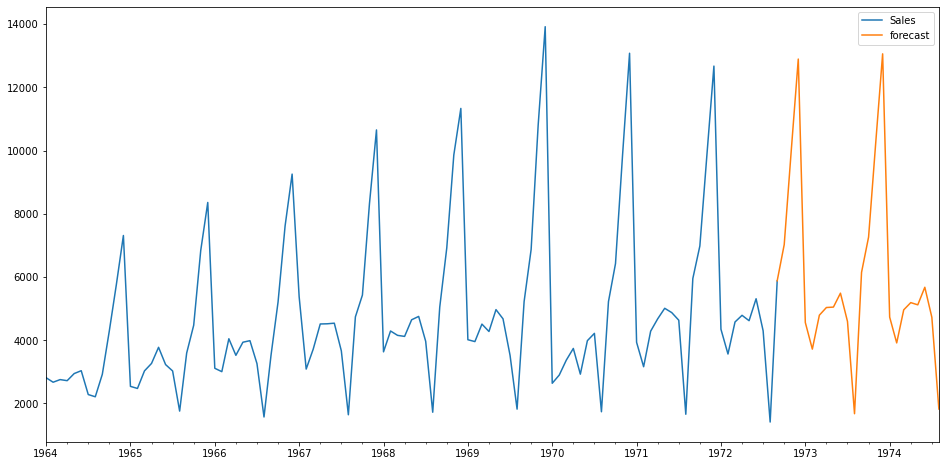

In [65]:
# Visualize (both current trend and predicted trend)
future_df[['Sales', 'forecast']].plot(figsize=(16, 8)) 

### THANK YOU